# Project proposal

In [37]:
library(tidyverse)

## Preliminary exploratory data analysis:

In [38]:
heart_data <- read_csv("heart.csv")
heart_data
#heart_data1 <- read_csv("processed.hungarian.data",col_names = c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","target"))
#heart_data1
#filtered <- filter(heart_data1, thal == "?")
#filtered

Rows: 1025 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
58,0,0,100,248,0,0,122,0,1.0,1,0,2,1
58,1,0,114,318,0,2,140,0,4.4,0,3,1,0
55,1,0,160,289,0,0,145,1,0.8,1,1,3,0
46,1,0,120,249,0,0,144,0,0.8,2,0,3,0


### Selecting only intrested columns from data set

In [39]:
heart_data_1 <- select(heart_data,age,cp,trestbps,chol,thalach,oldpeak) |> mutate(cp = as_factor(cp))
heart_data_1

age,cp,trestbps,chol,thalach,oldpeak
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
52,0,125,212,168,1.0
53,0,140,203,155,3.1
70,0,145,174,125,2.6
61,0,148,203,161,0.0
62,0,138,294,106,1.9
58,0,100,248,122,1.0
58,0,114,318,140,4.4
55,0,160,289,145,0.8
46,0,120,249,144,0.8


### Plotting graphs of all variables vs age and coloring them by cp 

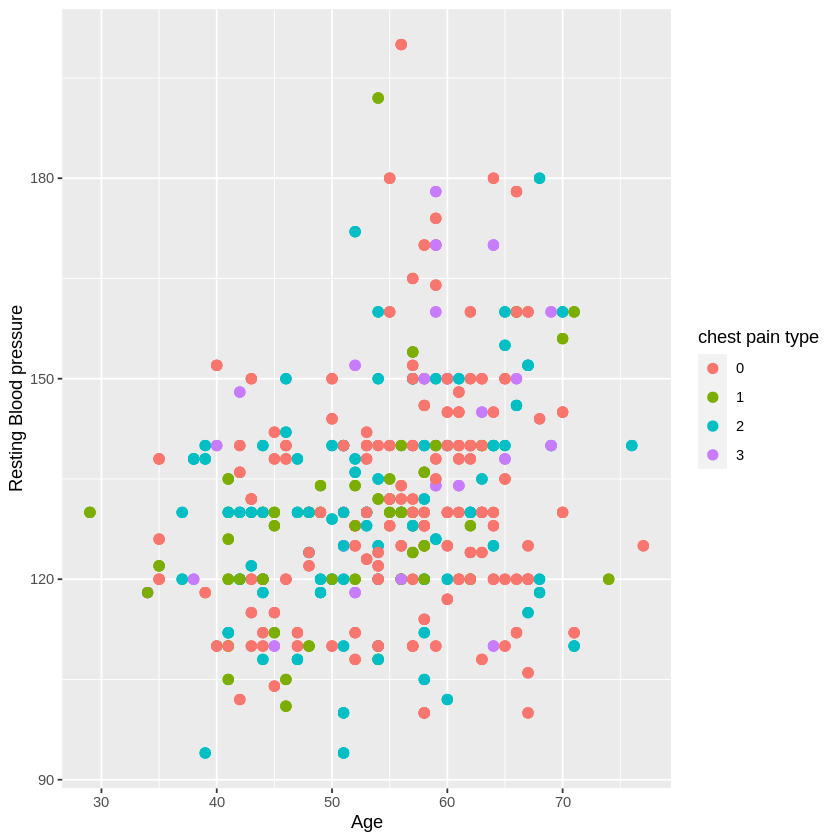

In [40]:
trestbps_plot <- heart_data_1 |> ggplot(aes(x = age, 
               y = trestbps, 
               colour = cp)) +
        labs(x = "Age",
             y = "Resting Blood pressure",
            colour = 'chest pain type')+ geom_point(size = 2.5)
trestbps_plot

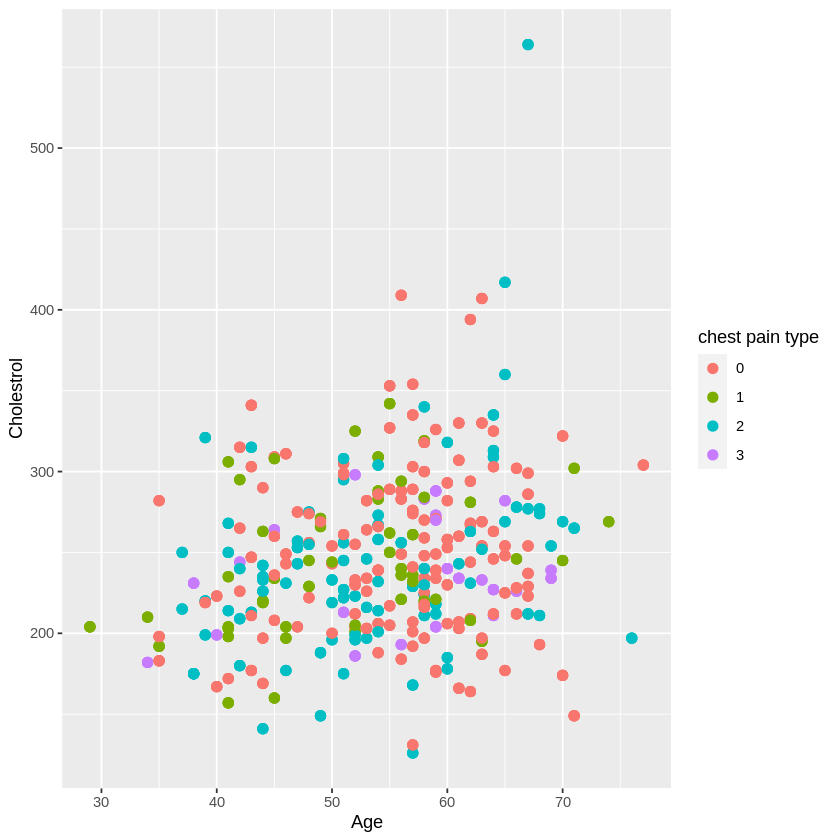

In [41]:
trestbps_plot <- heart_data_1 |> ggplot(aes(x = age, 
               y = chol, 
               colour = cp)) +
        labs(x = "Age",
             y = "Cholestrol",
            colour = 'chest pain type')+ geom_point(size = 2.5)
trestbps_plot

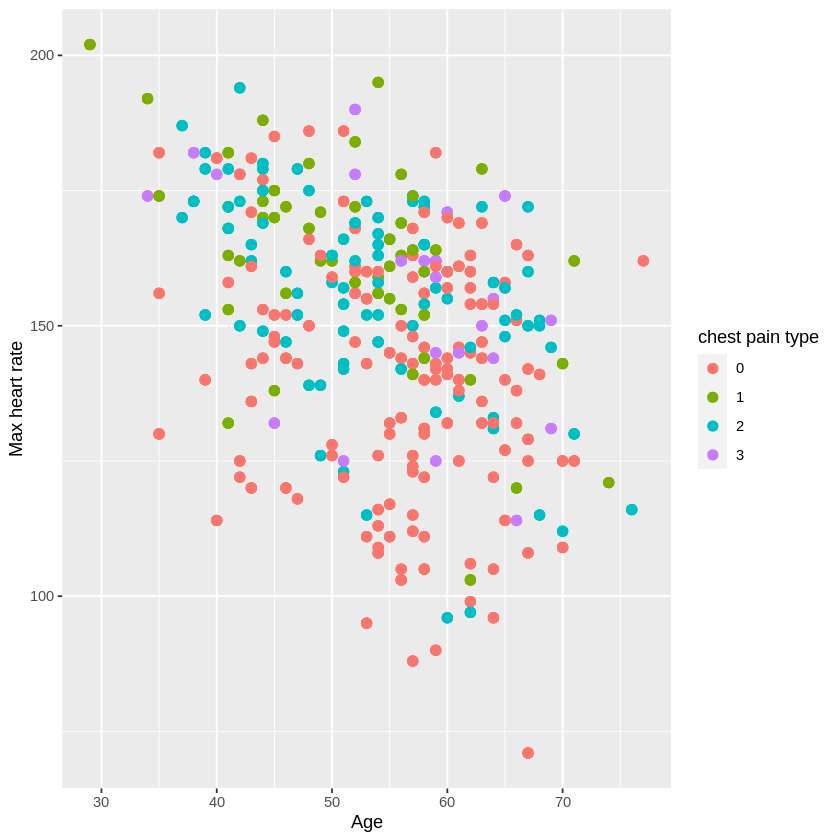

In [42]:
trestbps_plot <- heart_data_1 |> ggplot(aes(x = age, 
               y = thalach, 
               colour = cp)) +
        labs(x = "Age",
             y = "Max heart rate",
            colour = 'chest pain type')+ geom_point(size = 2.5)
trestbps_plot

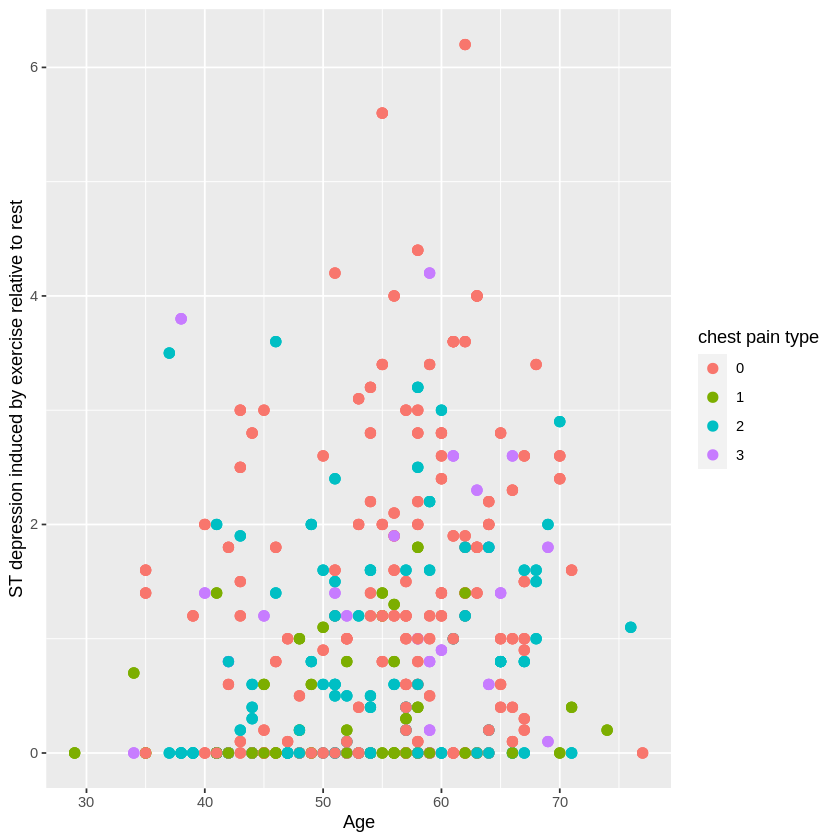

In [43]:
trestbps_plot <- heart_data_1 |> ggplot(aes(x = age, 
               y = oldpeak, 
               colour = cp)) +
        labs(x = "Age",
             y = "ST depression induced by exercise relative to rest",
            colour = 'chest pain type')+ geom_point(size = 2.5)
trestbps_plot

## Summary table

In [44]:
summary_table <- heart_data_1 |>
    group_by(cp) |>
    summarize(mean_age= mean(age,na.rm = TRUE),mean_trestbps= mean(trestbps,na.rm = TRUE),mean_chol= mean(chol,na.rm = TRUE),mean_thalach= mean(thalach,na.rm = TRUE),mean_oldpeak = mean(oldpeak,na.rm = TRUE), n())
summary_table

cp,mean_age,mean_trestbps,mean_chol,mean_thalach,mean_oldpeak,n()
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,55.78471,132.2133,249.9940,140.0523,1.4388330,497
1,51.24551,128.1198,244.7006,162.1796,0.3239521,167
2,53.51761,130.0775,242.1972,155.1162,0.7845070,284
3,56.01299,140.9610,237.0649,157.1299,1.3805195,77
